# Implementing Q-learning in a Gym environment


We will work out an example of the policy iteration algorithm on the Frozen Lake gym env

</b> https://gym.openai.com/envs/CartPole-v0/

## Environment breakdown

In [1]:
import gym
import numpy as np

In [2]:
env = gym.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
# 2 actions go left, go right
env.action_space

Discrete(2)

In [4]:
# 4 feature that describe our state which are:
# 1 - the Cart Position between -4.8 and 4.8
# 2 - Cart Velocity between -Inf and Inf
# 3 - Pole Angle between  -41.8 and  41.8°
# 4 - Pole Velocity At Tip between -Inf and Inf in degrees/second
env.observation_space.shape[0]

4

In [5]:
# lower bound on state space
env.observation_space.low

array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32)

In [11]:
# example of running the environment
env = gym.make('CartPole-v0')
env.reset()
for _ in range(100):
    env.render()
    observation, reward, done, info = env.step(env.action_space.sample())

env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


## Descretizing the state space

In [12]:
# state the number of dimensions for each feature of the state space
num_buckets = (1, 1, 6, 3)  # (position x, cart velocity x', pole angle theta, pole velocity theta')
num_actions = env.action_space.n  # (left, right)

In [13]:
# Create an array representing the bounds of each feature of the state space

state_bounds = list(zip(env.observation_space.low, env.observation_space.high))  # [(lower,upper), (lower,upper), etc. ]
state_bounds[1] = [-0.5, 0.5]  # bound criteria for the cart velocity
state_bounds[3] = [-np.radians(50), np.radians(50)]  # bound criteria for the pole velocity at Tip

state_bounds

[(-4.8, 4.8),
 [-0.5, 0.5],
 (-0.41887903, 0.41887903),
 [-0.8726646259971648, 0.8726646259971648]]

In [14]:
def state_to_bucket(state):
    '''Convert continous states to discrete buckets'''
    
    bucket_indice = []
    for feature in range(len(state)):
        
        # state is at extreme values
        if state[feature] <= state_bounds[feature][0]:
            bucket_index = 0 # first bucket index
        elif state[feature] >= state_bounds[feature][1]:
            bucket_index = num_buckets[feature] - 1 # get the last bucket index depending on number of buckets
        
        else:
            # Mapping the state bounds to the bucket array
            
            bound_width = state_bounds[feature][1] - state_bounds[feature][0] # Range of this state feature
            offset = (num_buckets[feature] - 1) * state_bounds[feature][0] / bound_width # 
            scaling = (num_buckets[feature] - 1) / bound_width
            bucket_index = int(round(scaling * state[feature] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

## Q-Learning


In [15]:
# create the Q-table
q_table = np.zeros(num_buckets + (num_actions,))  
q_table.shape

(1, 1, 6, 3, 2)

### Greedy action selection


In [16]:
def select_action(state, explore_rate):
    
    '''Select action given state with a small chance of taking a random action determind by explore_rate'''
    
    if np.random.random() < explore_rate:
        action = env.action_space.sample()
    else:
        action = np.argmax(q_table[state])

    return action

### decaying learning rate and epsilon value for greedy policy

In [17]:
def update_explore_rate(t):
    '''Decay explore_rate over time'''
    return max(0.1, min(1, 1.0 - np.log10((t + 1) / 25)))


def update_learning_rate(t):
    '''Decay learning_rate over time'''
    return max(0.1, min(1.0, 1.0 - np.log10((t + 1) / 25)))

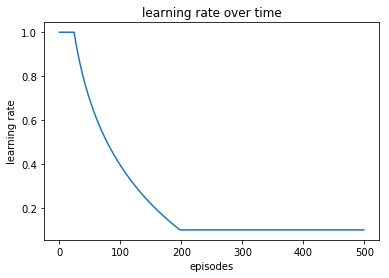

In [18]:
# Visualizing this decay
import matplotlib.pyplot as plt

t = np.arange(0, 500, 1)
y = []
for i in t:
    y.append(update_learning_rate(i))

plt.plot(t, y)
plt.xlabel("episodes")
plt.ylabel("learning rate")
plt.title("learning rate over time")
plt.show()

## Running algorithm

In [19]:
# define training process
max_episodes = 1000 # define the number of episode to iterate over
max_timestep = 200 # define the number of timesteps
discount = 1

for episode in range(max_episodes):

    obs = env.reset()  
    prev_state = state_to_bucket(obs)
    
    # define learning rate and greedy policy for this episode
    explore_rate = update_explore_rate(episode)
    learning_rate = update_learning_rate(episode)

    for t in range(max_timestep):

        # selet action        
        action = select_action(prev_state, explore_rate)
        
        # run action and observe outcome
        obs, reward, done, _ = env.step(action)
        
        # discretize next state
        next_state = state_to_bucket(obs)
        
        # update q table
        q_table[prev_state + (action,)] +=  learning_rate * (reward + \
            discount * np.amax(q_table[next_state]) - q_table[prev_state + (action,)] ) #amax = array max 
        prev_state = next_state

        if done:
            env.close()
            print('Episode:{}/{} finished at timestep:{}'.format(
                episode, max_episodes, t))
            break

Episode:0/1000 finished at timestep:23
Episode:1/1000 finished at timestep:22
Episode:2/1000 finished at timestep:11
Episode:3/1000 finished at timestep:14
Episode:4/1000 finished at timestep:16
Episode:5/1000 finished at timestep:23
Episode:6/1000 finished at timestep:11
Episode:7/1000 finished at timestep:45
Episode:8/1000 finished at timestep:25
Episode:9/1000 finished at timestep:26
Episode:10/1000 finished at timestep:12
Episode:11/1000 finished at timestep:17
Episode:12/1000 finished at timestep:38
Episode:13/1000 finished at timestep:35
Episode:14/1000 finished at timestep:21
Episode:15/1000 finished at timestep:13
Episode:16/1000 finished at timestep:17
Episode:17/1000 finished at timestep:15
Episode:18/1000 finished at timestep:14
Episode:19/1000 finished at timestep:16
Episode:20/1000 finished at timestep:46
Episode:21/1000 finished at timestep:24
Episode:22/1000 finished at timestep:38
Episode:23/1000 finished at timestep:54
Episode:24/1000 finished at timestep:21
Episode:25

Episode:212/1000 finished at timestep:199
Episode:213/1000 finished at timestep:199
Episode:214/1000 finished at timestep:199
Episode:215/1000 finished at timestep:199
Episode:216/1000 finished at timestep:199
Episode:217/1000 finished at timestep:199
Episode:218/1000 finished at timestep:199
Episode:219/1000 finished at timestep:199
Episode:220/1000 finished at timestep:199
Episode:221/1000 finished at timestep:199
Episode:222/1000 finished at timestep:199
Episode:223/1000 finished at timestep:199
Episode:224/1000 finished at timestep:199
Episode:225/1000 finished at timestep:199
Episode:226/1000 finished at timestep:199
Episode:227/1000 finished at timestep:199
Episode:228/1000 finished at timestep:199
Episode:229/1000 finished at timestep:199
Episode:230/1000 finished at timestep:199
Episode:231/1000 finished at timestep:199
Episode:232/1000 finished at timestep:199
Episode:233/1000 finished at timestep:199
Episode:234/1000 finished at timestep:199
Episode:235/1000 finished at times

Episode:425/1000 finished at timestep:199
Episode:426/1000 finished at timestep:199
Episode:427/1000 finished at timestep:199
Episode:428/1000 finished at timestep:199
Episode:429/1000 finished at timestep:199
Episode:430/1000 finished at timestep:199
Episode:431/1000 finished at timestep:199
Episode:432/1000 finished at timestep:199
Episode:433/1000 finished at timestep:199
Episode:434/1000 finished at timestep:199
Episode:435/1000 finished at timestep:199
Episode:436/1000 finished at timestep:199
Episode:437/1000 finished at timestep:199
Episode:438/1000 finished at timestep:199
Episode:439/1000 finished at timestep:199
Episode:440/1000 finished at timestep:199
Episode:441/1000 finished at timestep:199
Episode:442/1000 finished at timestep:199
Episode:443/1000 finished at timestep:199
Episode:444/1000 finished at timestep:199
Episode:445/1000 finished at timestep:199
Episode:446/1000 finished at timestep:199
Episode:447/1000 finished at timestep:199
Episode:448/1000 finished at times

Episode:636/1000 finished at timestep:199
Episode:637/1000 finished at timestep:199
Episode:638/1000 finished at timestep:199
Episode:639/1000 finished at timestep:199
Episode:640/1000 finished at timestep:199
Episode:641/1000 finished at timestep:199
Episode:642/1000 finished at timestep:199
Episode:643/1000 finished at timestep:199
Episode:644/1000 finished at timestep:199
Episode:645/1000 finished at timestep:199
Episode:646/1000 finished at timestep:199
Episode:647/1000 finished at timestep:199
Episode:648/1000 finished at timestep:199
Episode:649/1000 finished at timestep:199
Episode:650/1000 finished at timestep:199
Episode:651/1000 finished at timestep:199
Episode:652/1000 finished at timestep:199
Episode:653/1000 finished at timestep:199
Episode:654/1000 finished at timestep:199
Episode:655/1000 finished at timestep:199
Episode:656/1000 finished at timestep:199
Episode:657/1000 finished at timestep:199
Episode:658/1000 finished at timestep:199
Episode:659/1000 finished at times

Episode:846/1000 finished at timestep:199
Episode:847/1000 finished at timestep:199
Episode:848/1000 finished at timestep:199
Episode:849/1000 finished at timestep:199
Episode:850/1000 finished at timestep:199
Episode:851/1000 finished at timestep:199
Episode:852/1000 finished at timestep:199
Episode:853/1000 finished at timestep:199
Episode:854/1000 finished at timestep:199
Episode:855/1000 finished at timestep:199
Episode:856/1000 finished at timestep:199
Episode:857/1000 finished at timestep:199
Episode:858/1000 finished at timestep:199
Episode:859/1000 finished at timestep:199
Episode:860/1000 finished at timestep:199
Episode:861/1000 finished at timestep:199
Episode:862/1000 finished at timestep:199
Episode:863/1000 finished at timestep:199
Episode:864/1000 finished at timestep:199
Episode:865/1000 finished at timestep:199
Episode:866/1000 finished at timestep:199
Episode:867/1000 finished at timestep:199
Episode:868/1000 finished at timestep:199
Episode:869/1000 finished at times

## Visualize the final policy

In [24]:
env = gym.make('CartPole-v0')
state = env.reset()
state = state_to_bucket(state)

for _ in range(100):
    env.render()
    
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)
    state = state_to_bucket(state)

env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
